In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import io


In [3]:
path = '/content/drive/MyDrive/Random-images'

In [12]:
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)

#Resize images, if needed
train = train_datagen.flow_from_directory(path, 
                                          target_size=(256, 256), 
                                          batch_size=560, 
                                          class_mode=None)

Found 560 images belonging to 1 classes.


In [13]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) 
      Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

(560, 256, 256, 1)
(560, 256, 256, 2)


In [14]:
#Encoder

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same')) 


In [15]:
#Decoder
#Note: For the last layer we use tanh instead of Relu. 
#This is because we are colorizing the image in this layer using 2 filters, A and B.
#A and B values range between -1 and 1 so tanh (or hyperbolic tangent) is used
#as it also has the range between -1 and 1. 
#Other functions go from 0 to 1.
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

In [16]:
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 256)       590080    
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 512)       1180160   
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 512)      

In [17]:
model_history = model.fit(X,Y,validation_split=0.1, epochs=75, batch_size=16)

Epoch 1/75
32/32 [==============================] - 12s 243ms/step - loss: 0.1334 - accuracy: 0.5199 - val_loss: 0.0136 - val_accuracy: 0.5289
Epoch 2/75
32/32 [==============================] - 5s 166ms/step - loss: 0.0158 - accuracy: 0.5619 - val_loss: 0.0135 - val_accuracy: 0.5326
Epoch 3/75
32/32 [==============================] - 5s 166ms/step - loss: 0.0156 - accuracy: 0.5657 - val_loss: 0.0134 - val_accuracy: 0.5280
Epoch 4/75
32/32 [==============================] - 5s 168ms/step - loss: 0.0157 - accuracy: 0.5732 - val_loss: 0.0133 - val_accuracy: 0.5633
Epoch 5/75
32/32 [==============================] - 5s 168ms/step - loss: 0.0154 - accuracy: 0.5831 - val_loss: 0.0130 - val_accuracy: 0.5686
Epoch 6/75
32/32 [==============================] - 5s 169ms/step - loss: 0.0152 - accuracy: 0.5958 - val_loss: 0.0126 - val_accuracy: 0.5911
Epoch 7/75
32/32 [==============================] - 5s 170ms/step - loss: 0.0149 - accuracy: 0.6043 - val_loss: 0.0125 - val_accuracy: 0.5932
Epoch

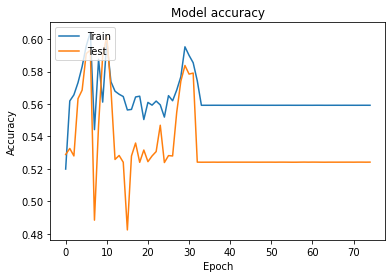

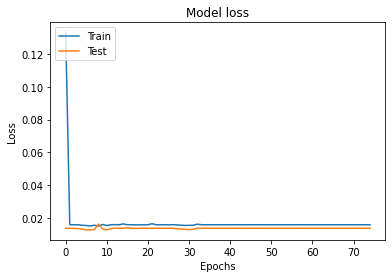

In [18]:
# Plot training & validation accuracy values  
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values  
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [35]:
model.save('/content/img_colorize_autoencoder.model')

INFO:tensorflow:Assets written to: /content/img_colorize_autoencoder.model/assets


INFO:tensorflow:Assets written to: /content/img_colorize_autoencoder.model/assets


In [36]:
tf.keras.models.save_model(model,'img_colorize_autoencoder.hdf5')

In [21]:
model2 = tf.keras.models.load_model('/content/img_colorize_autoencoder.hdf5')

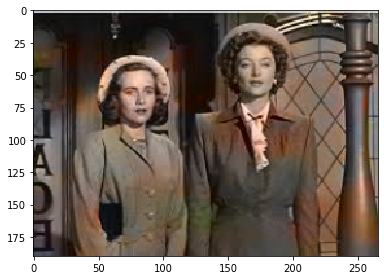

In [31]:
img1_color=[]
image=load_img('/content/images-_1_.jpg')
width, height = image.size
img1 = img_to_array(image)
img1 = resize(img1 ,(256,256))
img1_color.append(img1)
img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))
output1 = model2.predict(img1_color)
output1 = output1*128
result = np.zeros((256, 256, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]
img2 = lab2rgb(result)
img2 = resize(img2 ,(height,width))
myimg = io.imread("/content/images-_1_.jpg") 
io.imshow(img2)


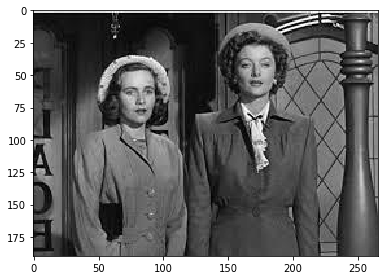

In [32]:
io.imshow(myimg)